## Business Problem

Real Estate firm wants a model to help them accurately price houses.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


## Load Data

In [2]:
df_column_names = ('data/column_names.md')
df_house = pd.read_csv('data/kc_house_data.csv')

In [3]:
df_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


   - id - unique identifier for a house
   - date - Date house was sold
   - price - Price is prediction target
   - bedrooms - Number of Bedrooms/House
   - bathrooms - Number of bathrooms/bedrooms
   - sqft_livingsquare - footage of the home
   - sqft_lotsquare - footage of the lot
   - floorsTotal - floors (levels) in house
   - waterfront - House which has a view to a waterfront
   - view - Has been viewed
   - condition - How good the condition is ( Overall )
   - grade - overall grade given to the housing unit, based on King County grading system
   - sqft_above - square footage of house apart from basement
   - sqft_basement - square footage of the basement
   - yr_built - Built Year
   - yr_renovated - Year when house was renovated
   - zipcode - zip
   - lat - Latitude coordinate
   - long - Longitude coordinate
   - sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
   - sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

## Data Exploration 

In [4]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
# Fields with nulls: waterfront, view,  yr_renovated


In [6]:
# print top 5 most frequent values in each column
for col in df_house.columns:
    print(col, '\n', df_house[col].value_counts(normalize=True).head(), '\n\n')

id 
 795000620     0.000139
1825069031    0.000093
2019200220    0.000093
7129304540    0.000093
1781500435    0.000093
Name: id, dtype: float64 


date 
 6/23/2014    0.006575
6/25/2014    0.006066
6/26/2014    0.006066
7/8/2014     0.005880
4/27/2015    0.005834
Name: date, dtype: float64 


price 
 350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
Name: price, dtype: float64 


bedrooms 
 3    0.454878
4    0.318655
2    0.127796
5    0.074131
6    0.012594
Name: bedrooms, dtype: float64 


bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
Name: bathrooms, dtype: float64 


sqft_living 
 1300    0.006390
1400    0.006251
1440    0.006158
1660    0.005973
1010    0.005973
Name: sqft_living, dtype: float64 


sqft_lot 
 5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
7500    0.005510
Name: sqft_lot, dtype: float64 


floors 
 1.0    0.494189
2.0    0.381303
1.5    

In [7]:
df_house['waterfront'].value_counts(normalize=True)
# Make waterfront boolean where nulls are non waterfront properties

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64

In [8]:
df_house['view'].value_counts(normalize=True)
# Make view boolean where nulls are properties without a view

0.0    0.901923
2.0    0.044441
3.0    0.023591
1.0    0.015325
4.0    0.014721
Name: view, dtype: float64

In [9]:
df_house['yr_renovated'].value_counts(normalize=True)
# Make yr_renovated boolean where nulls are unrenovated properties

0.0       0.958096
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1946.0    0.000056
1959.0    0.000056
1971.0    0.000056
1951.0    0.000056
1954.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

In [10]:
# check all unique values for 'grade'
grade_values = list(df_house['grade'].unique())
grade_values.sort()
grade_values

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [11]:
# check all unique values for 'condition'
condition_values = list(df_house['condition'].unique())
condition_values.sort()
condition_values

[1, 2, 3, 4, 5]

In [12]:
# check for identical home
sum(df_house.duplicated(subset=['id']))

177

In [13]:
# check for identical home / sale date rows
sum(df_house.duplicated(subset=['id','date']))

0

In [14]:
### is it an issue that the same home was sold several times for model?

In [15]:
df_house['date'].value_counts(normalize=True)

6/23/2014     0.006575
6/25/2014     0.006066
6/26/2014     0.006066
7/8/2014      0.005880
4/27/2015     0.005834
                ...   
8/30/2014     0.000046
11/2/2014     0.000046
1/10/2015     0.000046
11/30/2014    0.000046
5/24/2015     0.000046
Name: date, Length: 372, dtype: float64

### distribution of data?

## Data Preparation

### Remove unecessary features
Before removing features we will want to run tests to see which features are highly correlated or important to the model. However there are three columns I believe are reasonable to remove.
#### Columns to remove:
   - id - unique identifier for a house
    - not needed for modeling
   - lat - Latitude coordinate
   - long - Longitude coordinate
    - zipcode is easier to work with so we'll be using this for location instead of lat and long
   

### Missing Values

In [16]:
# Fields with nulls: waterfront, view,  yr_renovated
df_house.waterfront.fillna(0, inplace=True)
df_house.view.fillna(0, inplace=True)
df_house.yr_renovated.fillna(0, inplace=True)

### Reformat Data

In [17]:
# Convert sqft_basement col to basement col which indicates whether or not there is a basement
# assume '0.0' and '?' values mean no basement
df_house['sqft_basement'] = df_house['sqft_basement'].map(lambda x: 0 if x == '?' else x)
# convert column to float
df_house['sqft_basement'] = df_house['sqft_basement'].astype('float')
# add column called basement
df_house['basement'] = df_house['sqft_basement'].map(lambda x: 1 if x > 0 else 0)
# remove the 'sqft_basement' column
df_house = df_house.drop(['sqft_basement'], axis=1)

In [18]:
# Change scale of grade to 0 - 10 so it's more intuitive
df_house['grade'] = df_house['grade'].map(lambda x: x-3)
grade_values = list(df_house['grade'].unique())
grade_values.sort()
grade_values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [19]:
# define function for year renovated only counting houses renovated 2000 or later as being renovated
def renovation(year):
    if year >= 2000:
        return 1
    else:
        return 0

In [20]:
# apply function to the 'yr_renovated' column
df_house['yr_renovated']  = df_house['yr_renovated'].apply(renovation)

# rename column
df_house.rename({'yr_renovated': 'Renovated_in_2000s'}, axis=1, inplace=True)
df_house['Renovated_in_2000s'].value_counts()

0    21218
1      379
Name: Renovated_in_2000s, dtype: int64

In [21]:
# binary classification of view
def views(count):
    if count > 0:
        return 1
    else:
        return 0

In [22]:
# apply function to 'view' column
df_house['view'] = df_house['view'].apply(views)
# rename view column
df_house.rename({'view': 'viewed'}, axis=1, inplace=True)

In [23]:
df_house['viewed'].value_counts(normalize=True)

0    0.902209
1    0.097791
Name: viewed, dtype: float64

### Data Type Conversions

In [24]:
# convert to datetime
df_house['date'] = pd.to_datetime(df_house['date'])
# convert zipcode to category
df_house['zipcode']=df_house['zipcode'].astype('category')


### Continuous and Categorical

In [25]:
# assign continous variables to a list
continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


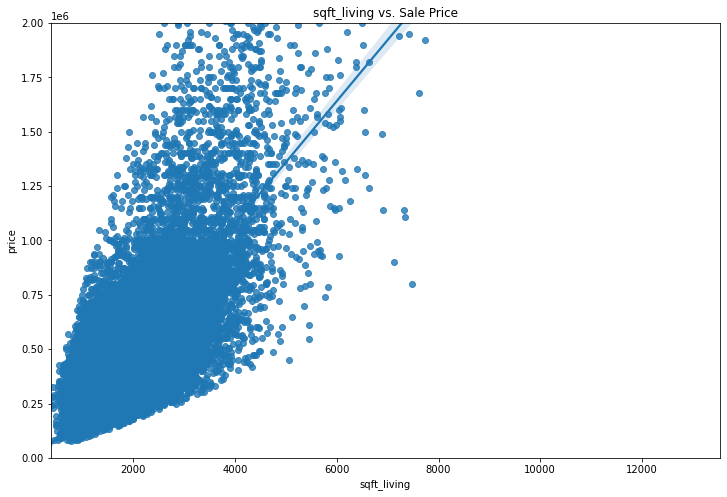

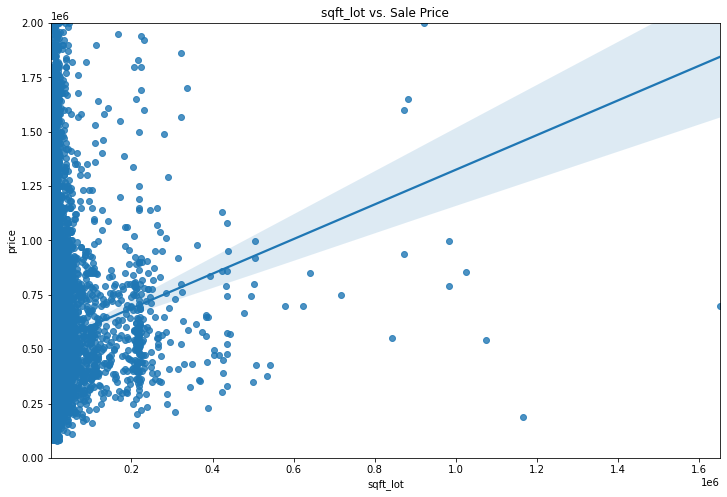

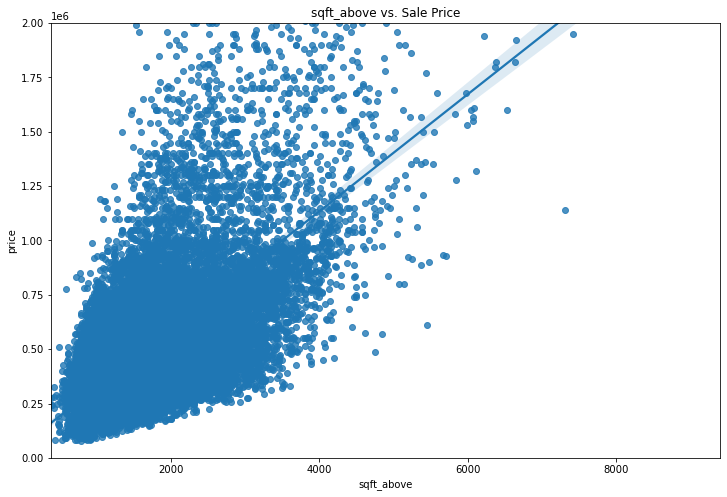

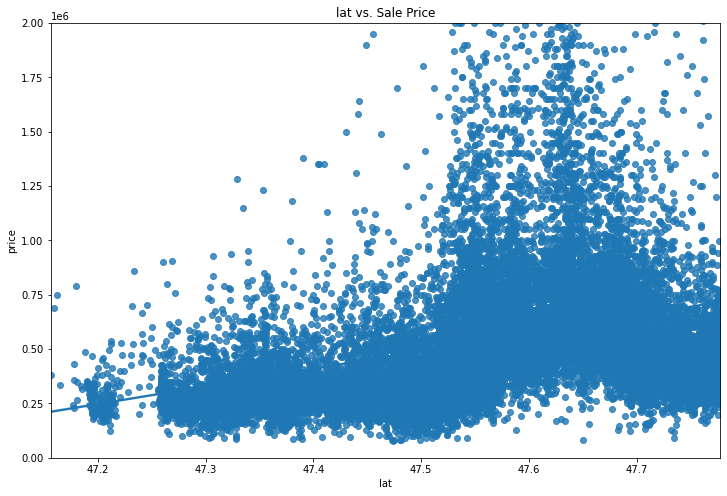

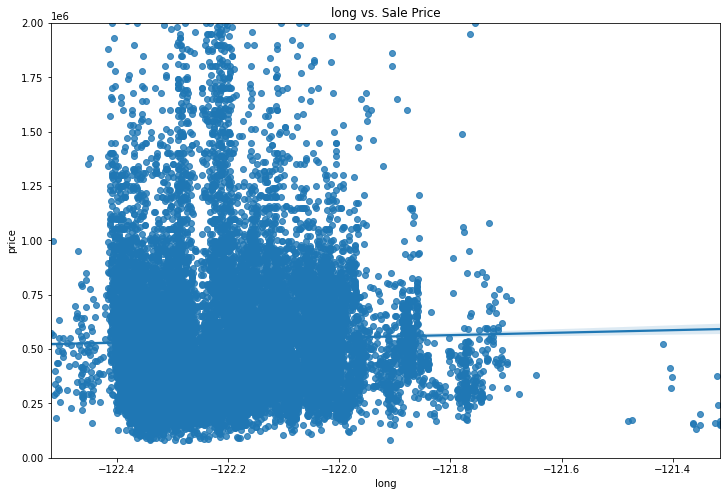

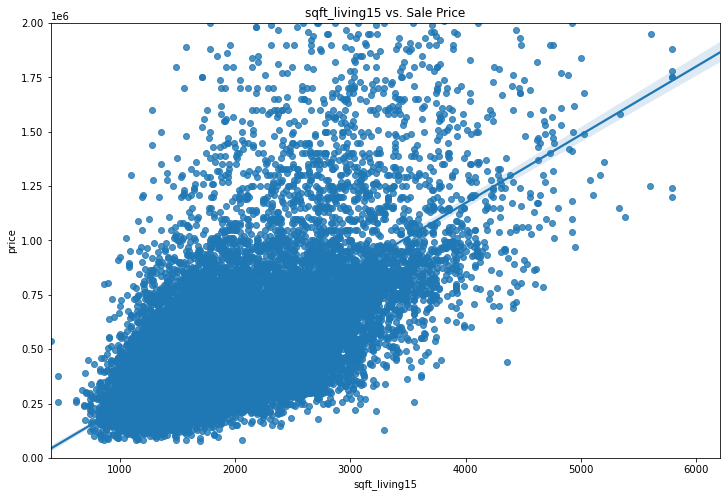

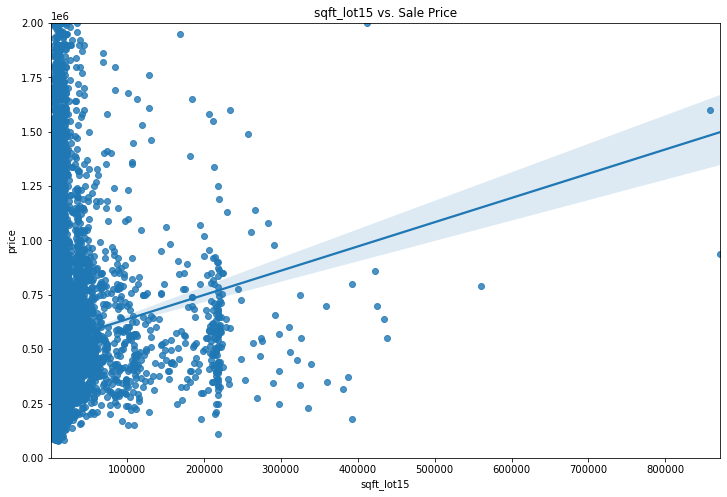

In [26]:
# price vs continuous variables
for variable in continuous:
    ax, figure = plt.subplots(1,1,figsize=(12,8))
    plt.ylim(0,2000000)
    sns.regplot(x=variable, y='price', data=df_house)
    plt.title("{} vs. Sale Price".format(variable))


In [27]:
# assign categorical variables to a list
categorical = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'viewed', 'condition', 'grade', 
                         'yr_built', 'Renovated_since_1980', 'zipcode', 'year_sold', 'month_sold', 'season_sold',
                         'basement']

ValueError: Could not interpret input 'Renovated_since_1980'

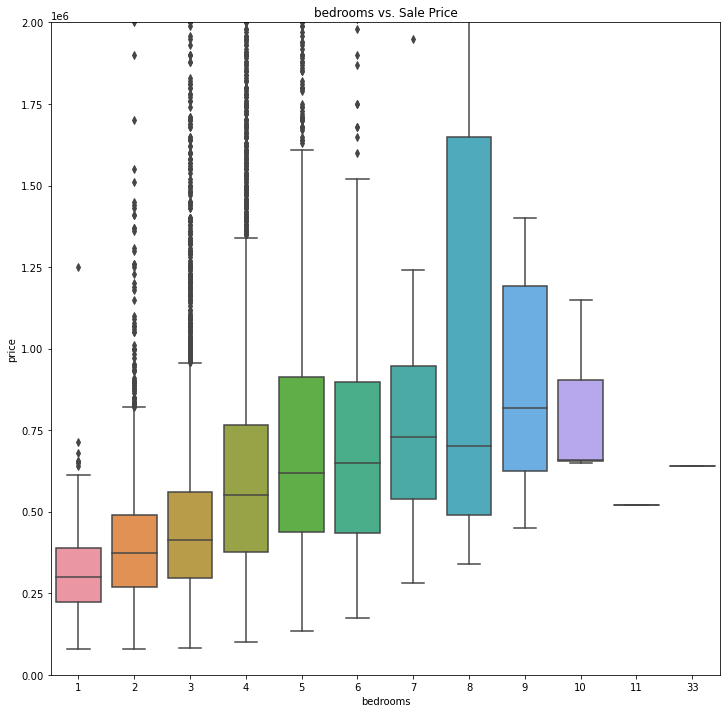

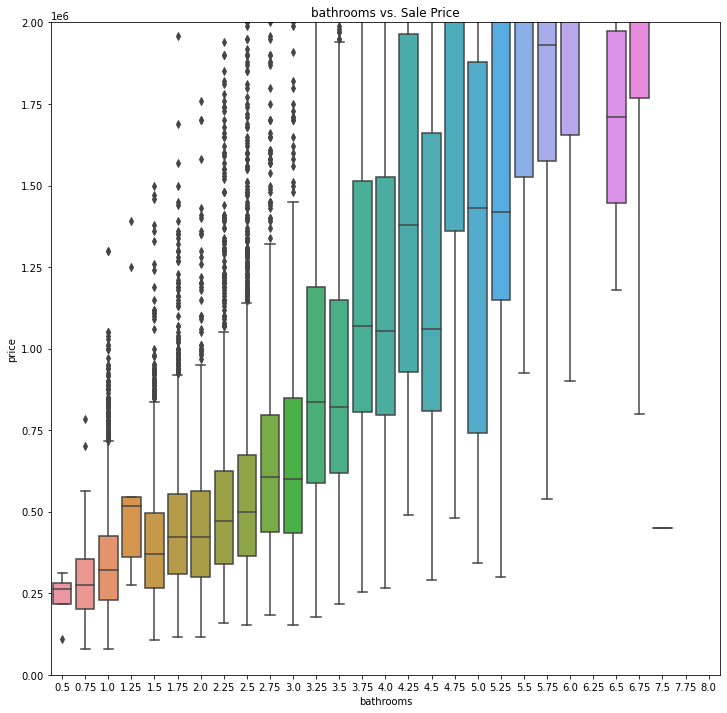

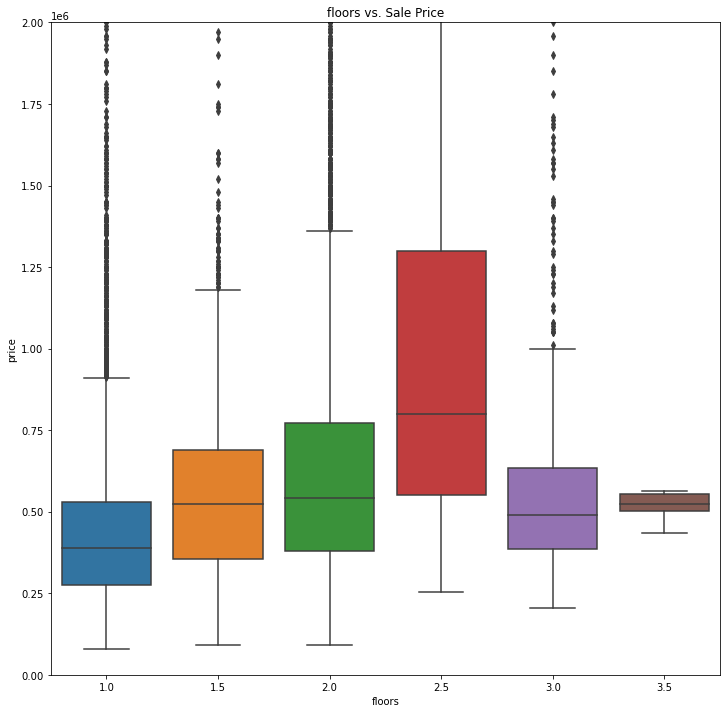

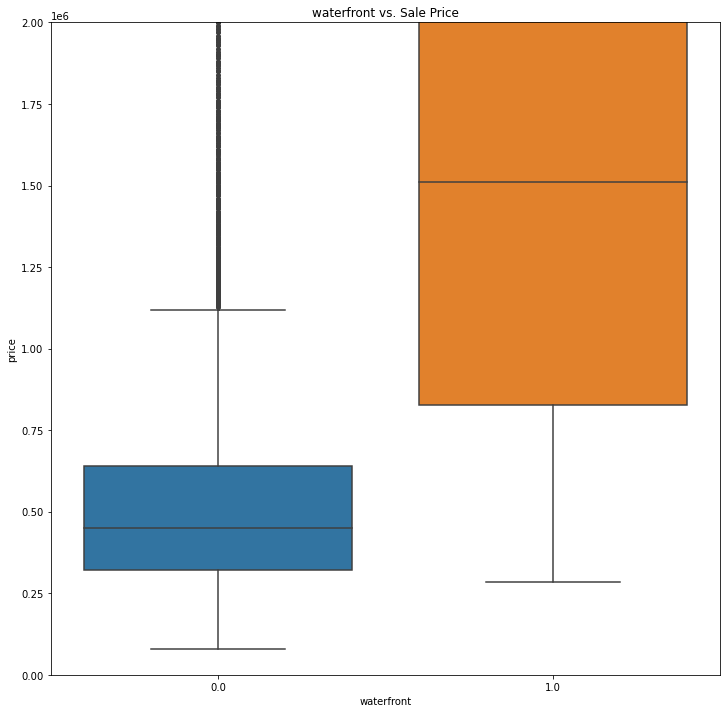

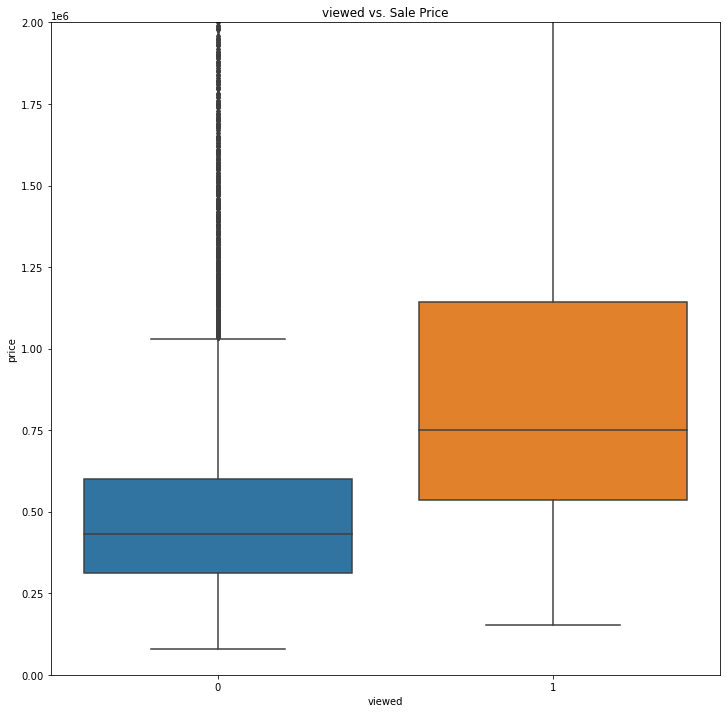

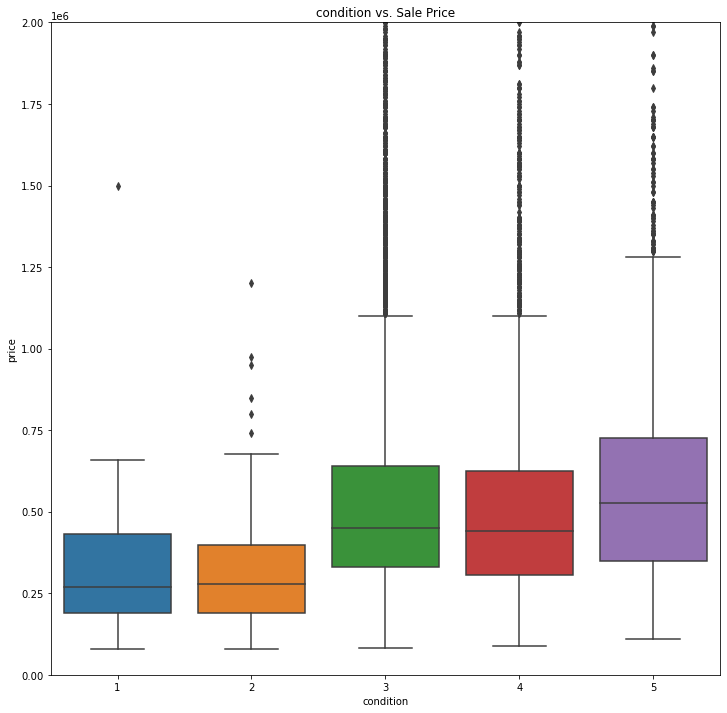

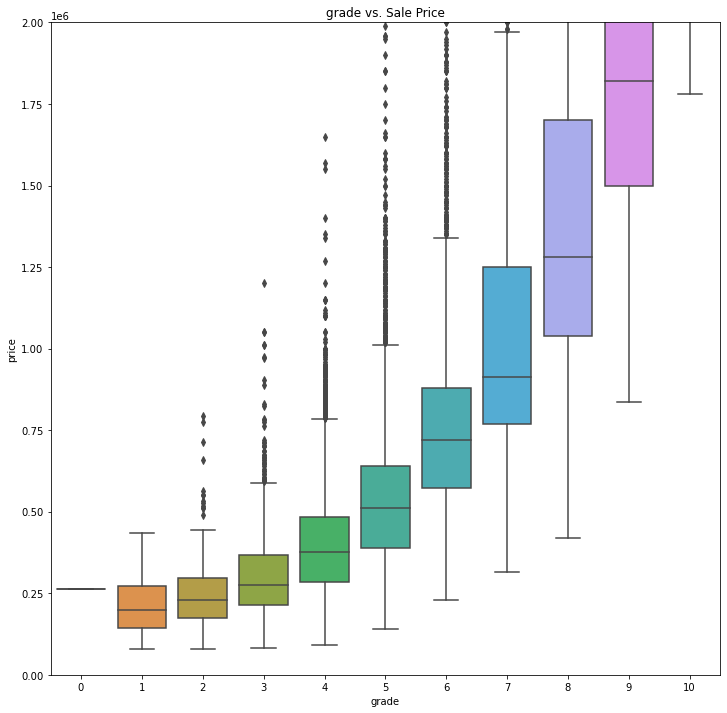

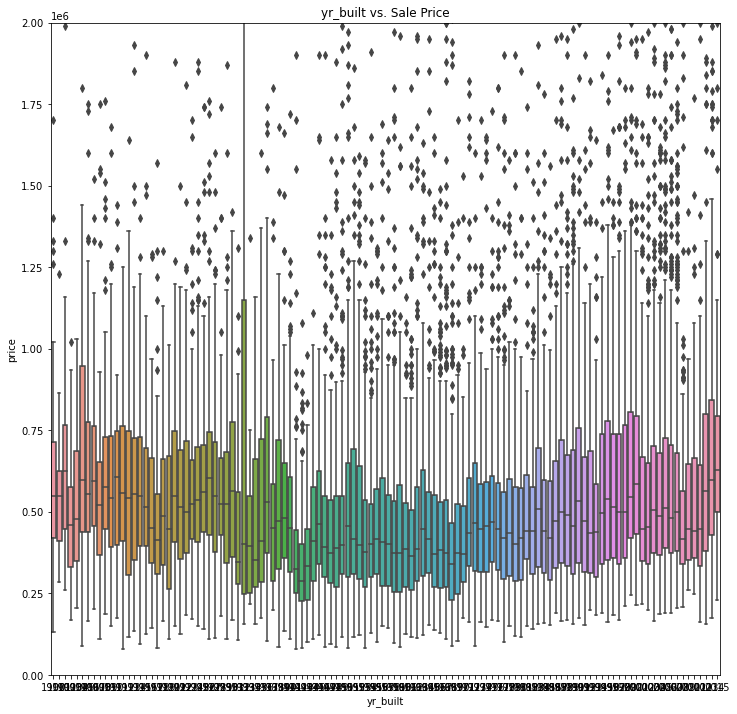

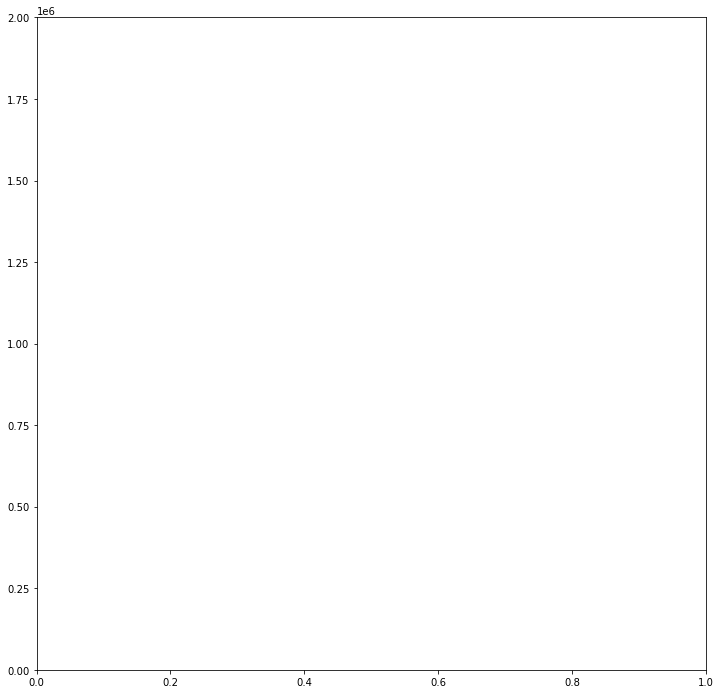

In [28]:
# price vs categorical variables
for variable in categorical:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(0,2000000)
    sns.boxplot(x=variable, y='price', data=df_house)
    plt.title("{} vs. Sale Price".format(variable))


### one-hot encode categorical variables

In [ ]:
# Convert category variables data type
categoricals= ['condition_grp','zipcode']
kc[categoricals] = kc[categoricals].astype('category')

In [ ]:
# one hot encode categoricals
kc_ohe = pd.get_dummies(kc[categoricals], drop_first=True)
kc_ohe.head()

In [ ]:
# Concatenate OHE columns with original dataframe, dropping OHE original features
kc_comb = pd.concat([kc, kc_ohe], axis=1)
kc_comb.drop(['id','date','lat','long','home_lat_long'], axis=1, inplace=True)
kc_comb.head()

### Normalize numeric variables

### Multicollinearity

In [ ]:
pd.plotting.scatter_matrix(df_features,figsize  = [20, 20]);
plt.show()

In [ ]:
df_features = df_house.drop(['price'], axis=1)

In [ ]:
# Check for collinearity among potential predicator values by pairs
df=corr.stack().reset_index().sort_values(0, ascending=False)
# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index to pairs
df.set_index(['pairs'], inplace = True)
#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)
# rename correlation column as cc rather than 0
df.columns = ['correlation']
# drop duplicates
df.drop_duplicates(inplace=True)
df[abs(df.correlation) > .65]

In [ ]:
sns.heatmap(df_features.corr(), center=0);

In [ ]:
df_features.corr()

In [ ]:
# features correlated above .7 considered highly correlated
abs(df_features.corr()) > 0.7

In [ ]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=df_features.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
df.drop_duplicates(inplace=True)

In [ ]:
df[(df.cc>.7) & (df.cc <1)]

- Remove: sqft_above,sqft_living15, sqft_lot15
- Keeping: grade, sqft_living, bathrooms 
 - (intuitively # of bathrooms, grade, and sqft_living should be important for house pricing)


In [ ]:
df_house = df_house.drop(['sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)

### Normalize numeric data

### Create Features

In [ ]:
# add column price per square foot
df_house['price_per_sf'] = df_house.apply(lambda row: row['price'] / row['sqft_living'], axis=1)

In [ ]:
# bin house sizes and group by house size
def sqft_bin(sqft):
    if sqft < 1000:
        home_size = '< 1000 sqft'
    elif 1000 <= sqft < 2000:
        home_size = '1000 to 2000 sqft'
    elif 2000 <= sqft < 3000:
        home_size = '2000 to 3000 sqft'
    elif 3000 <= sqft < 4000:
        home_size = '3000 to 4000 sqft'
    else:
        home_size = '> 4000 sqft'
    return home_size
        
# apply function to sqft_living
df_house['sqft_bin'] = df_house['sqft_living'].apply(sqft_bin)

In [ ]:
# sqft bin vs. Price per Sqaure Foot Visualization

### split data test and train?

In [ ]:
# Divide dataset into X predictors and y target
X = kc_comb.drop(['price','price_log','price_box'], axis=1)
y = kc_comb[['price','price_log','price_box']]

In [ ]:
# Split the data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:

# Validate rows in splits look as expected
print(len(X_train), len(X_test), len(y_train), len(y_test))

In [ ]:
# X_train[X_train.isna().any(axis=1)]
# X_test[X_test.isna().any(axis=1)]
y_train[y_train.isna().any(axis=1)]
y_test[y_test.isna().any(axis=1)]

### create model

In [ ]:

model = linearregression()
#model.fit(x,y)